In [7]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from torchvision import models
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import MiniBatchKMeans
import os

In [2]:
# map
with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])


In [3]:
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

In [4]:
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image

    bow_vector = np.zeros(n_centroids)

    for i in range(n_descriptors):
        idx = np.argmin(np.linalg.norm(centroids - img_descriptors[i], axis=1), axis=0)
        bow_vector[idx] += 1
    return bow_vector

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, json_path, transform=None):
        self.transform=transform
        self.root_dir = root_dir
        with open(json_path,"r") as f:
            m_idx = json.load(f)
            self.m_imgs = np.array(m_idx["im_paths"])

    def __len__(self):
        return len(self.m_imgs)

    def __getitem__(self, idx):
        img = plt.imread(os.path.join(self.root_dir, self.m_imgs[idx]))

        if self.transform:
            img = self.transform(img)
        return img

In [26]:
# def create_deep_descriptors():
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loaded device: {device}")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), antialias=False)
])

batch_size = 64

database = CustomDataset(root_dir="data02", json_path="data02/database/database_lite.json", transform=transform)
loader = DataLoader(database, batch_size=batch_size)

kmeans = MiniBatchKMeans(n_clusters=32, random_state=0, batch_size=batch_size, n_init=3)

# Find centroids
print("Finding centroids...")
for img in tqdm_notebook(loader):
    img = img.to(device)
    with torch.no_grad():
        output = model(img)

        kmeans.partial_fit(output.cpu().numpy()[:, :, 0, 0])

centroids = kmeans.cluster_centers_

# Create BoVW vectors
print("Finding centroids...")
bow_map_images = None
for img in tqdm_notebook(loader):
    img = img.to(device)
    with torch.no_grad():
        output = model(img)
        for i_batch in range(output.shape[0]):
            bow = bag_of_words(centroids, output.cpu().numpy()[i_batch, :, 0, 0])
            if bow_map_images is None:
                bow_map_images = bow
            else:
                bow_map_images = np.vstack( (bow_map_images, bow))

Loaded device: cuda
Finding centroids...


C:\Users\koend\AppData\Local\Temp\ipykernel_21776\2244254465.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm_notebook(loader):


  0%|          | 0/16 [00:00<?, ?it/s]

Finding centroids...


C:\Users\koend\AppData\Local\Temp\ipykernel_21776\2244254465.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm_notebook(loader):


  0%|          | 0/16 [00:00<?, ?it/s]

In [188]:
centroids.shape

(32, 2048)

In [10]:
bow_map_images.shape

(1000, 32)

In [39]:
# def create_sift_discriptors():
#     descriptors = None
#
#     for img_name in tqdm.notebook.tqdm(m_imgs):
#         img = plt.imread(os.path.join('data02', img_name))
#         img = rgb2gray(img)
#
#         sift.detect_and_extract(img)
#         # sift_descriptors = sift.descriptors[:100, :]
#
#         if descriptors is None:
#             descriptors = sift.descriptors[:100, :]
#         else:
#             descriptors = np.vstack((descriptors, sift.descriptors[:100, :]))
#
#     return descriptors

In [40]:
# descriptors = create_sift_discriptors()

C:\Users\koend\AppData\Local\Temp\ipykernel_9000\1631892576.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_name in tqdm_notebook(m_imgs):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
# from sklearn.cluster import KMeans
#
# K = 32
# num_initialization = 5
#
# kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
# clusters = kmeans.fit(descriptors)
# centroids = clusters.cluster_centers_

Initialization complete
Iteration 0, inertia 14070951697.0.
Iteration 1, inertia 9463617913.264824.
Iteration 2, inertia 9259379959.256943.
Iteration 3, inertia 9180029875.323826.
Iteration 4, inertia 9143737184.853268.
Iteration 5, inertia 9122667837.821638.
Iteration 6, inertia 9107919673.445663.
Iteration 7, inertia 9095918933.775944.
Iteration 8, inertia 9085582589.280796.
Iteration 9, inertia 9076060691.24808.
Iteration 10, inertia 9068352949.532953.
Iteration 11, inertia 9061941690.298817.
Iteration 12, inertia 9056646513.283619.
Iteration 13, inertia 9051919949.779318.
Iteration 14, inertia 9047791285.841015.
Iteration 15, inertia 9044270772.116282.
Iteration 16, inertia 9041438423.306128.
Iteration 17, inertia 9039302775.194098.
Iteration 18, inertia 9037717971.08154.
Iteration 19, inertia 9036406828.85915.
Iteration 20, inertia 9035042556.89499.
Iteration 21, inertia 9033712015.789122.
Iteration 22, inertia 9032423973.317078.
Iteration 23, inertia 9031264783.432491.
Iteration 

In [121]:
print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")

Shape of the centroids matrix:  (32, 2048)
We computed  32 centroids of lengh  2048  (the same of the descriptor)


In [34]:
# query_img = plt.imread(os.path.join("data02", m_imgs[0]))
# query_img = rgb2gray(query_img)
# sift.detect_and_extract(query_img)

In [36]:
# bow_map_images = None
#
# for img_name in tqdm.notebook.tqdm(m_imgs):
#     img = plt.imread(os.path.join('data02', img_name))
#     img = rgb2gray(img)
#
#     sift.detect_and_extract(img)
#     img_descriptors = sift.descriptors[:100, :]  # descriptors (the feature vectors)
#
#     # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
#     bow = bag_of_words(centroids, img_descriptors)
#     # add the computed BoW vector to the set of map representations
#     if bow_map_images is None:
#         bow_map_images = bow
#     else:
#         bow_map_images = np.vstack( (bow_map_images, bow))

C:\Users\koend\AppData\Local\Temp\ipykernel_9000\3454419259.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_name in tqdm_notebook(m_imgs):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
from sklearn import preprocessing
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)

In [12]:
bow_map_images.shape

(1000, 32)

In [46]:
def retrieve_images(map_bow_vectors, query_bow):
    # dists = np.linalg.norm(map_bow_vectors - query_bow, axis=1)
    #
    # idxs = np.argsort(np.linalg.norm(map_bow_vectors - query_bow, axis=1))
    # print(dists[idxs][:10])
    return np.argsort(np.linalg.norm(map_bow_vectors - query_bow, axis=1))

q_database = CustomDataset(root_dir="data02", json_path="data02/query/query_lite.json", transform=transform)
# q_loader = DataLoader(database, batch_size=1)

# query_idx = 100
for query_idx in range(len(q_database)):
    img = q_database[query_idx]
    img = img.to(device)

    # compute bag of words
    with torch.no_grad():
        q_img_descriptors = model(img[None, :])
        bow = bag_of_words(centroids, q_img_descriptors.cpu().numpy()[:, :, 0, 0])

    # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
    # bow = scaler.transform(bow.reshape(-1, 1).transpose())
    bow = bow.transpose().reshape(-1)

    # # Retrieve the indices of the top-10 similar images from the map
    retrieved_images = retrieve_images(bow_map_images, bow)
    # print('Indices of similar images retrieved: ', retrieved_images[:10])
    # # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
    relevant_images = np.where(sim[query_idx, :] == 1)[0]
    # print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)
    print(f"{query_idx}: {len(set(retrieved_images[:100]).intersection(set(relevant_images)))} / {len(relevant_images)}")
    # if len(set(retrieved_images).intersection(set(relevant_images))) != len(relevant_images):
    #     print(f"{query_idx}: {len(set(retrieved_images).intersection(set(relevant_images)))} / {len(relevant_images)}")

NameError: name 'CustomDataset' is not defined

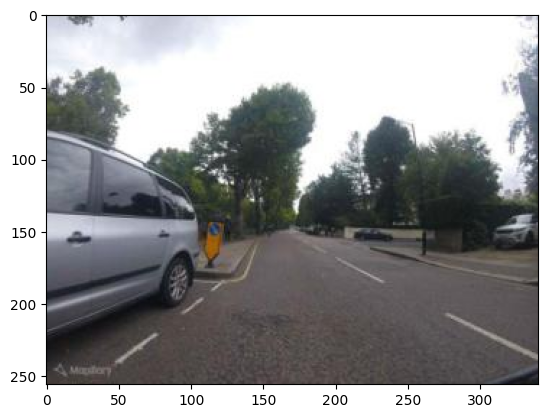

In [180]:
import os
img = plt.imread(os.path.join('data02', q_imgs[32]))
plt.imshow(img)

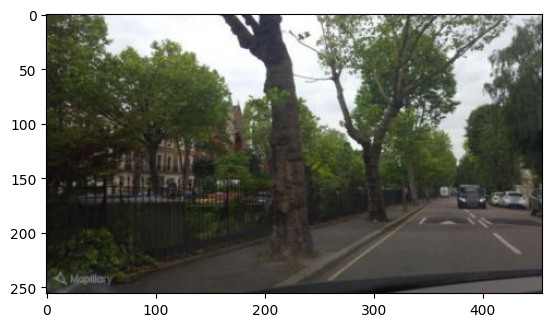

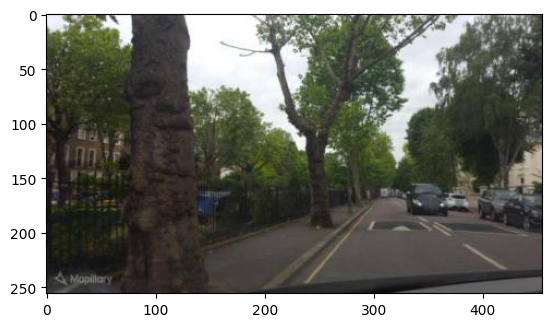

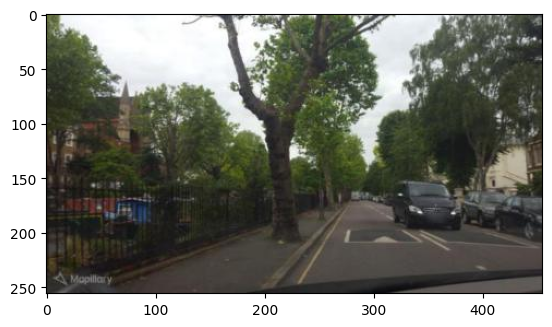

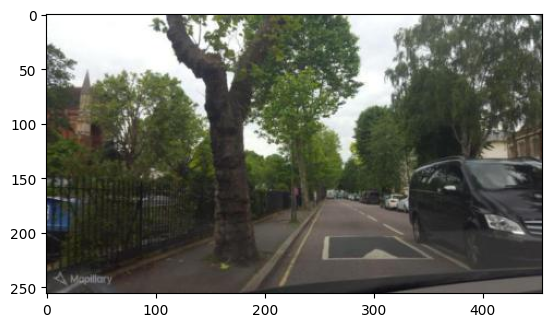

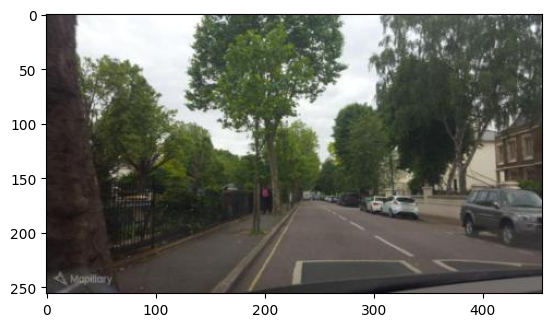

In [181]:
for i in np.where(sim[32, :] == 1)[0]:
    img1 = plt.imread(os.path.join('data02', m_imgs[i]))
    plt.imshow(img1)
    plt.show()

In [157]:
## BEGIN ANSWER
def precision_at_k(relevant, retrieved, k):
    tp = np.sum(np.in1d(relevant, retrieved[:k]))
    fp = len(relevant) - tp
    return tp / (tp + fp)

prec5 = precision_at_k(relevant_images, retrieved_images, 5)
prec10 = precision_at_k(relevant_images, retrieved_images, 10)
## END ANSWER

print('P@5: ', prec5)
print('P@10: ', prec10)

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,